# Quickstart
First let import the modules to work with.  Some functionalities of MolDrug may be not available on pypi or conda yet. This could be because the new version is not yet release, but in brief it is going to be. You could install directly from the repo if some problem pops up. Just paste the following in a code cell:
```bash
! pip install git+https://github.com/ale94mleon/MolDrug.git@main

In [1]:
from rdkit import Chem
from moldrug import utils, fitness
from moldrug.data import receptors, ligands, boxes
import tempfile, os, gzip, shutil, requests
from multiprocessing import cpu_count

We will use the some test examples on the `moldrug.data` module.

In [3]:
# Creating a temporal directory
tmp_path = tempfile.TemporaryDirectory()
# Creating receptors files
r_x0161_file = os.path.join(tmp_path.name, 'r_x0161.pdbqt')
with open(r_x0161_file, 'w') as r:
    r.write(receptors.r_x0161)

Now let's download the crem data base. Here we are downloading the smaller one. But consider to visit [CReM](https://github.com/DrrDom/crem) for more information about how to use and create the data base of fragments.

In [4]:
url = "http://www.qsar4u.com/files/cremdb/replacements02_sc2.db.gz"
r = requests.get(url, allow_redirects=True)
crem_dbgz_path = os.path.join(tmp_path.name,'crem.db.gz')
crem_db_path = os.path.join(tmp_path.name,'crem.db')
open(crem_dbgz_path, 'wb').write(r.content)
with gzip.open(crem_dbgz_path, 'rb') as f_in:
    with open(crem_db_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

Now We initialize the `GA` class. 

In [5]:
maxiter = 3
popsize = 20
njobs = 2

out = utils.GA(
    seed_smiles=ligands.r_x0161,
    maxiter=maxiter,
    popsize=popsize,
    crem_db_path = crem_db_path,#'/home/ale/GITLAB/bi_crem_database/replacements02_sc2.db',
    pc = 1,
    get_similar = False,
    mutate_crem_kwargs = {
        'radius':3,
        'min_size':1,
        'max_size':8,
        'min_inc':-5,
        'max_inc':3,
        'ncores':cpu_count(),
    },
    costfunc = fitness.Cost,#__CostSimilarity,# __VinaCostLipinski, Cost, __VinaCost, __QedSasVinaCost, CostMultiReceptors
    costfunc_kwargs = {
        'vina_executable': 'vina',
        'receptor_path': r_x0161_file,
        'boxcenter' : boxes.r_x0161["A"]['boxcenter'] ,
        'boxsize': boxes.r_x0161["A"]['boxsize'],
        'exhaustiveness': 4,
        'ncores': int(cpu_count() / njobs),
        'num_modes': 1,
    },
    save_pop_every_gen = 20,
    deffnm = os.path.join(tmp_path.name, 'pop_test_single_receptor')
)


Then we call the class

In [6]:
out(njobs = njobs)



Creating the first population with 20 members:


100%|██████████| 20/20 [00:42<00:00,  2.14s/it]

Initial Population: Best individual: Individual(idx = 5, smiles = NS(=O)(=O)c1ccc(C2(O)CCNCC2)cc1, cost = 0.6076297216634597)
File /tmp/tmpna40vpr7/pop_test_single_receptor_pop.sdf was createad!


Evaluating generation 1 / 3:


100%|██████████| 20/20 [00:50<00:00,  2.52s/it]

Generation 1: Best Individual: Individual(idx = 22, smiles = NS(=O)(=O)c1ccc(COc2cccc(O)c2)cc1, cost = 0.5945198669617732).



Evaluating generation 2 / 3:


100%|██████████| 20/20 [00:53<00:00,  2.69s/it]

Generation 2: Best Individual: Individual(idx = 22, smiles = NS(=O)(=O)c1ccc(COc2cccc(O)c2)cc1, cost = 0.5945198669617732).



Evaluating generation 3 / 3:


100%|██████████| 20/20 [01:07<00:00,  3.37s/it]


File /tmp/tmpna40vpr7/pop_test_single_receptor_pop.sdf was createad!
Generation 3: Best Individual: Individual(idx = 22, smiles = NS(=O)(=O)c1ccc(COc2cccc(O)c2)cc1, cost = 0.5945198669617732).


=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

The simulation finished successfully after 3 generations with a population of 20 individuals. A total number of 80 Individuals were seen during the simulation.
Initial Individual: Individual(idx = 0, smiles = COC(=O)C=1C=CC(=CC1)S(=O)(=O)N, cost = 1.0)
Final Individual: Individual(idx = 22, smiles = NS(=O)(=O)c1ccc(COc2cccc(O)c2)cc1, cost = 0.5945198669617732)
The cost fucntion droped in 0.40548013303822683 units.

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

'__call__'  268894.03 ms


This is a very silly example. In real life, you should increase the population size and the number of generation. In this way we explore in a better way ther chemical space. The `GA` clas has some nice methods that give you an idea of the obtained results.

In [7]:
out.to_dataframe().tail()

,smiles,idx,pdbqt,cost,qed,sa_score,vina_score
75,COC(=O)C(O)c1ccc(-c2n[nH]c(=O)o2)cc1,75,MODEL 1\nREMARK VINA RESULT: -6.4 0....,0.594520,0.755540,2.892714,-6.4
76,O=C1NNC(=O)C1c1ccc(C=C[N+](=O)[O-])cc1,76,MODEL 1\nREMARK VINA RESULT: -6.6 0....,0.621832,0.451535,2.958459,-6.6
77,NC(=O)CC(NS(=O)(=O)c1ccc(S(N)(=O)=O)cc1)C(=O)O,77,MODEL 1\nREMARK VINA RESULT: -6.6 0....,0.628105,0.434328,2.501670,-6.6
78,CCNC(=O)Cc1ccc(S(N)(=O)=O)cc1,78,MODEL 1\nREMARK VINA RESULT: -5.8 0....,1.000000,0.779195,1.724182,-5.8
79,C#CC(OC(N)=O)c1ccc(C(=O)CI)cc1,79,MODEL 1\nREMARK VINA RESULT: -5.7 0....,1.000000,0.393880,3.346737,-5.7


You could save the entire class for future use both in a compressed file. Here I just saved the file in the temporal directory, you could change the path to your current working directory.

In [8]:
out.pickle(os.path.join(tmp_path.name, f"NumGens_{out.NumGens}_PopSize_{popsize}"), compress=True)

But Could be that after a long simulation we would like to perform a different searching strategy over the last population. This is really simple, we could initialize againg the `out` instance with a differnt set of parameters. Let say that we would like close to the last solutions. Then we could use the parameters: `min_size=0, max_size=1, min_inc=-1, max_inc=1`.This flavor will add, delate mutate heavy atoms or change Hydrogens for heavy atoms.

In [9]:
out.maxiter = 5
out.mutate_crem_kwargs = {
        'radius':3,
        'min_size':0,
        'max_size':1,
        'min_inc':-1,
        'max_inc':1,
        'ncores':cpu_count(),
    }

And run againg the class

In [10]:
out(njobs = njobs)

File /tmp/tmpna40vpr7/pop_test_single_receptor_pop.sdf was createad!
Evaluating generation 4 / 8:


100%|██████████| 20/20 [01:03<00:00,  3.19s/it]

Generation 4: Best Individual: Individual(idx = 87, smiles = COC(=O)C(C)c1ccc(-c2n[nH]c(=O)o2)cc1, cost = 0.5358411166387222).



Evaluating generation 5 / 8:


100%|██████████| 20/20 [00:58<00:00,  2.91s/it]

Generation 5: Best Individual: Individual(idx = 87, smiles = COC(=O)C(C)c1ccc(-c2n[nH]c(=O)o2)cc1, cost = 0.5358411166387222).



Evaluating generation 6 / 8:


100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

Generation 6: Best Individual: Individual(idx = 121, smiles = CC(C)(C)NC(=O)c1ccc(S(=O)(=O)NO)cc1F, cost = 0.5179094169238212).



Evaluating generation 7 / 8:


100%|██████████| 19/19 [01:03<00:00,  3.33s/it]

Generation 7: Best Individual: Individual(idx = 147, smiles = NS(=O)(=O)c1ccc(CN=Cc2cccc(CO)c2)cc1, cost = 0.5113675970405873).



Evaluating generation 8 / 8:


100%|██████████| 15/15 [00:46<00:00,  3.09s/it]

File /tmp/tmpna40vpr7/pop_test_single_receptor_pop.sdf was createad!
Generation 8: Best Individual: Individual(idx = 167, smiles = Cc1cc(CO)cc(OCc2ccc(S(=O)(=O)NN)cc2)c1, cost = 0.48338878867372415).


=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

The simulation finished successfully after 5 generations with a population of 20 individuals. A total number of 171 Individuals were seen during the simulation.
Initial Individual: Individual(idx = 0, smiles = COC(=O)C=1C=CC(=CC1)S(=O)(=O)N, cost = 1.0)
Final Individual: Individual(idx = 167, smiles = Cc1cc(CO)cc(OCc2ccc(S(=O)(=O)NN)cc2)c1, cost = 0.48338878867372415)
The cost fucntion droped in 0.5166112113262759 units.

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

'__call__'  304808.34 ms


As you can see the `GA` class is updated reather that replacead. This is a perfect feature for rerun with different ideas. As you see the number of generations is also updatead as well the number of calls.

In [11]:
print(out.NumGens, out.NumCalls)

8 2


The same idea is for the rest of the methods and atributtes

In [12]:
out.to_dataframe().tail()

,smiles,idx,pdbqt,cost,qed,sa_score,vina_score
166,Cc1cc(C(=O)NC(C)(C)C)c(F)cc1S(=O)(=O)NO,166,MODEL 1\nREMARK VINA RESULT: -6.3 0....,0.634625,0.734102,2.497032,-6.3
167,Cc1cc(CO)cc(OCc2ccc(S(=O)(=O)NN)cc2)c1,167,MODEL 1\nREMARK VINA RESULT: -7.2 0....,0.483389,0.548100,2.135742,-7.2
168,Cc1cc(S(=O)(=O)NO)cc(F)c1C(=O)NC(C)(C)C,168,MODEL 1\nREMARK VINA RESULT: -6.6 0....,0.539657,0.734102,2.574871,-6.6
169,CNCc1cccc(C=NCc2ccc(S(N)(=O)=O)cc2)c1,169,MODEL 1\nREMARK VINA RESULT: -6.1 0....,0.744564,0.794899,2.256445,-6.1
170,O=S(=O)(NO)c1ccc(C2CCNCC2)c(I)c1,170,MODEL 1\nREMARK VINA RESULT: -6.7 0....,0.568989,0.546100,2.767147,-6.7


This is the best solution of this simulation (you for sure, will get a different one):

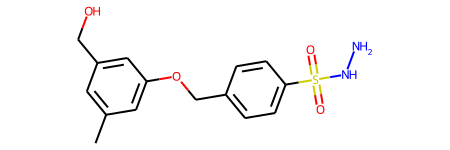

In [13]:
Chem.MolFromSmiles(out.pop[0].smiles)

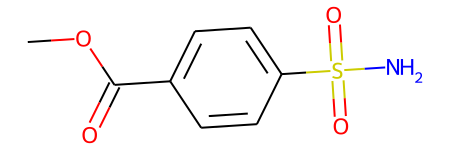

In [14]:
from rdkit import Chem
Chem.MolFromSmiles("COC(=O)C=1C=CC(=CC1)S(=O)(=O)N")

Printing some information

Initial vina score: -5.1. Final vina score: -7.2
sascorer of the best Individual: 2.1357422726974757
QED of the best Individual: 0.5480998943776431
{
  "NumHAcceptors": 5,
  "NumHDonors": 3,
  "wt": 322.3860000000001,
  "MLogP": 1.2183199999999996,
  "NumRotatableBonds": 6,
  "TPSA": 101.65,
  "FractionCSP3": 0.2,
  "HeavyAtomCount": 22,
  "NHOHCount": 4,
  "NOCount": 6,
  "NumAliphaticCarbocycles": 0,
  "NumAliphaticHeterocycles": 0,
  "NumAliphaticRings": 0,
  "NumAromaticCarbocycles": 2,
  "NumAromaticHeterocycles": 0,
  "NumAromaticRings": 2,
  "NumHeteroatoms": 7,
  "NumSaturatedCarbocycles": 0,
  "NumSaturatedHeterocycles": 0,
  "NumSaturatedRings": 0,
  "RingCount": 2
}


[Text(0.5, 1.0, 'bestcost')]

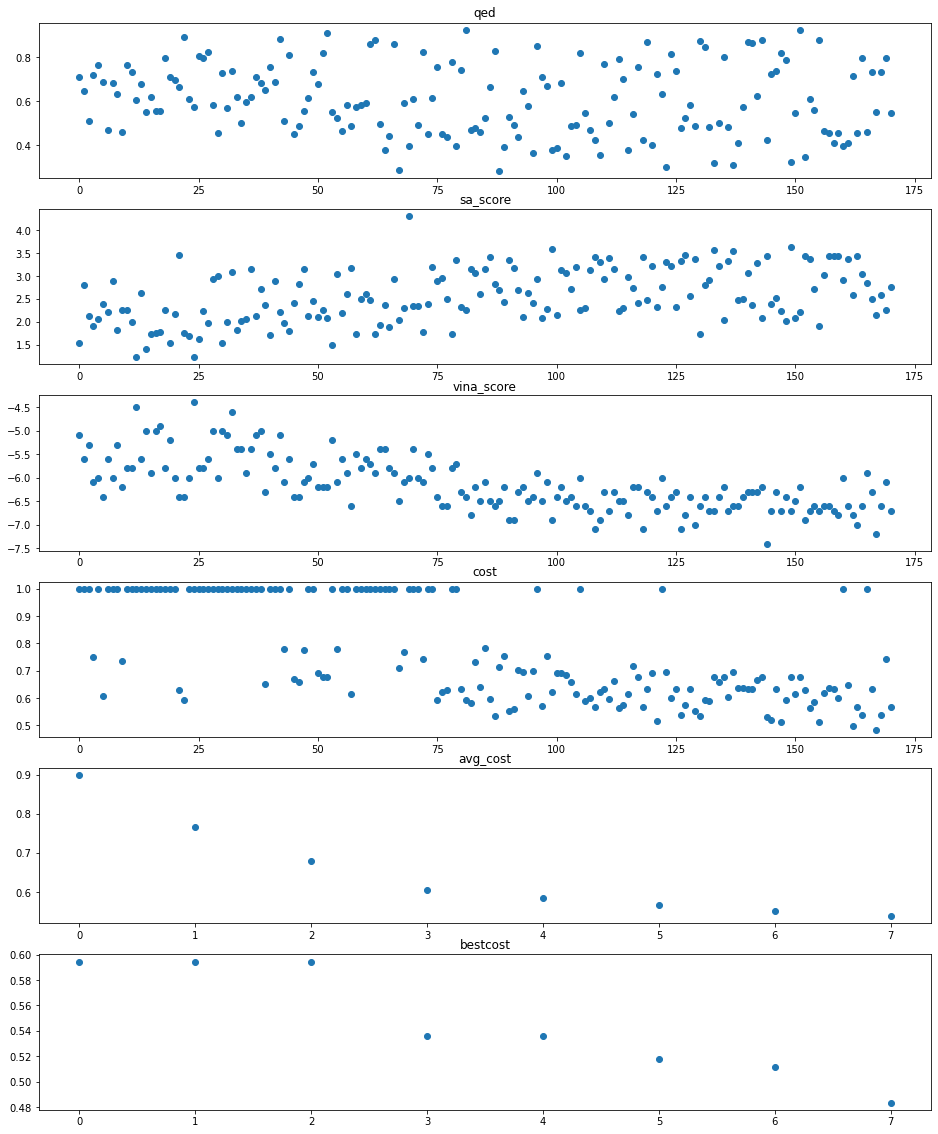

In [15]:
import json
import matplotlib.pyplot as plt
from moldrug import utils
sascorer = utils.import_sascorer()
print(f"Initial vina score: {out.InitIndividual.vina_score}. Final vina score: {out.pop[0].vina_score}")
print(f"sascorer of the best Individual: {sascorer.calculateScore(out.pop[0].mol)}")
print(f"QED of the best Individual: {fitness.QED.weights_mean(out.pop[0].mol)}")
print(json.dumps(utils.lipinski_profile(out.pop[0].mol), indent = 2))

fig, ax = plt.subplots(nrows = 6, figsize = (16,20))

ax[0].plot(range(len(out.SawIndividuals)),[Individual.qed for Individual in out.SawIndividuals], 'o')
ax[0].set(title = 'qed')

ax[1].plot(range(len(out.SawIndividuals)),[Individual.sa_score for Individual in out.SawIndividuals], 'o')
ax[1].set(title = 'sa_score')

ax[2].plot(range(len(out.SawIndividuals)),[Individual.vina_score for Individual in out.SawIndividuals], 'o')
ax[2].set(title = 'vina_score')

ax[3].plot(range(len(out.SawIndividuals)),[Individual.cost for Individual in out.SawIndividuals], 'o')
ax[3].set(title = 'cost')

ax[4].plot(range(len(out.avg_cost)),out.avg_cost, 'o')
ax[4].set(title = 'avg_cost')

ax[5].plot(range(len(out.bestcost)),out.bestcost, 'o')
ax[5].set(title = 'bestcost')
